<a href="https://colab.research.google.com/github/novtryrezki/Terbaru/blob/main/2CNN_bs_64_ep_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import random
import shutil
import numpy as np
import tensorflow as tf
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split

In [2]:
# Melakukan mount pada Google Drive
drive.mount('/content/drive')

# Menentukan path file ZIP di Google Drive
zip_path = '/content/drive/MyDrive/images.zip'

# Membuat objek zip_ref
zip_ref = zipfile.ZipFile(zip_path, 'r')

# Mengekstrak file ZIP
extract_path ='/content/images'
zip_ref.extractall(extract_path)

# Tutup objek zip_ref setelah selesai
zip_ref.close()

Mounted at /content/drive


In [3]:
# Mendefinisikan path direktori dataset
dataset_dir = os.path.join(extract_path, 'images')
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
list_train = sorted(os.listdir(train_dir))
list_test = sorted(os.listdir(test_dir))

print("Daftar Angka pada Dataset Train yaitu : ", list_train)
print("Daftar Angka pada Dataset Test yaitu : ", list_test)

Daftar Angka pada Dataset Train yaitu :  ['angka 0', 'angka 1', 'angka 2', 'angka 3', 'angka 4', 'angka 5', 'angka 6', 'angka 7', 'angka 8', 'angka 9']
Daftar Angka pada Dataset Test yaitu :  ['angka 0', 'angka 1', 'angka 2', 'angka 3', 'angka 4', 'angka 5', 'angka 6', 'angka 7', 'angka 8', 'angka 9']


In [4]:
def count_images(directory):
    return sum(1 for file in os.listdir(directory) if file.endswith(('.jpg', '.jpeg', '.png', '.gif')))

# Menghitung jumlah gambar di data train
train_image_count = sum(count_images(os.path.join(train_dir, angka)) for angka in list_train)

# Menghitung jumlah gambar di data test
test_image_count = sum(count_images(os.path.join(test_dir, angka)) for angka in list_test)

print(f"Jumlah gambar di Dataset Train: {train_image_count}")
print(f"Jumlah gambar di Dataset Test: {test_image_count}")

Jumlah gambar di Dataset Train: 1763
Jumlah gambar di Dataset Test: 445


# Preprocessing

In [5]:
import cv2

def resize_images(directory, target_resolution):
    for angka in os.listdir(directory):
        angka_dir = os.path.join(directory, angka)
        for file_name in os.listdir(angka_dir):
            file_path = os.path.join(angka_dir, file_name)
            img = cv2.imread(file_path)
            resized_img = cv2.resize(img, (target_resolution[0], target_resolution[1]))
            cv2.imwrite(file_path, resized_img)

target_resolution = (52, 78)
resize_images(train_dir, target_resolution)
resize_images(test_dir, target_resolution)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Membuat generator data dengan augmentasi
image_size = (52, 78)
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 1763 images belonging to 10 classes.
Found 445 images belonging to 10 classes.


# Membuat Model CNN

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
import math

img_size = 52*78*1

# Perhitungan jumlah neuron pada lapisan tersembunyi
hidden_neurons1 = 548
hidden_neurons2 = 74

model2c = Sequential()
model2c.add(Conv2D(32, (3, 3), input_shape=(52, 78, 1)))
model2c.add(AveragePooling2D((2, 2)))
model2c.add(Conv2D(64, (3, 3)))
model2c.add(AveragePooling2D((2, 2)))
model2c.add(Flatten())
model2c.add(Dense(hidden_neurons1, activation='relu'))
model2c.add(Dense(hidden_neurons2, activation='relu'))
model2c.add(Dense(10, activation='softmax'))

model2c.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Mendapatkan bobot dari model
weights = []
for layer in model2c.layers:
    weights.append(layer.get_weights())

print("Bobot dari model:")
for i, layer_weights in enumerate(weights):
    print("Layer", i+1)
    for j, w in enumerate(layer_weights):
        print("  Bobot {}: {}".format(j+1, w.shape))

Bobot dari model:
Layer 1
  Bobot 1: (3, 3, 1, 32)
  Bobot 2: (32,)
Layer 2
Layer 3
  Bobot 1: (3, 3, 32, 64)
  Bobot 2: (64,)
Layer 4
Layer 5
Layer 6
  Bobot 1: (12672, 548)
  Bobot 2: (548,)
Layer 7
  Bobot 1: (548, 74)
  Bobot 2: (74,)
Layer 8
  Bobot 1: (74, 10)
  Bobot 2: (10,)


In [9]:
# Menampilkan matriks bobot dan vektor bias dari setiap layer
for i, layer in enumerate(model2c.layers):
    weights = layer.get_weights()
    if weights:
        print("Layer", i+1)
        for j, w in enumerate(weights):
            if j == 0:
                print("  Bobot:")
            else:
                print("  Bias:")
            print("    Ukuran:", w.shape)
            print("    Nilai:")
            print(w)

Layer 1
  Bobot:
    Ukuran: (3, 3, 1, 32)
    Nilai:
[[[[ 0.01276991  0.00306003 -0.10999801  0.08392157  0.01817581
     0.08811401 -0.10103447 -0.03394207  0.00072244  0.10856743
     0.0070859  -0.11493692 -0.06845036  0.02017581 -0.03019806
     0.03550448  0.13587712  0.00902136 -0.025529   -0.08302203
     0.07374878  0.01369788  0.04565668  0.08735865 -0.06802592
    -0.0779804  -0.13235702  0.05378073  0.01399967  0.077833
    -0.09937843  0.05103853]]

  [[ 0.0257061  -0.09504922 -0.09456805 -0.06373873  0.11326684
     0.08144554 -0.05970252  0.06207928 -0.09457757  0.03838477
    -0.08916492 -0.10431395 -0.0653758   0.07129209  0.11702071
     0.01227216 -0.14165251  0.04556563 -0.10773301 -0.00994912
     0.044228    0.03845102 -0.1263804   0.12578209  0.11289875
    -0.07940743 -0.06695844 -0.0667273   0.00113136 -0.11675691
    -0.05381639  0.02973065]]

  [[ 0.0837241  -0.00037706  0.13565002 -0.05582211  0.07212406
     0.14010833  0.09965238 -0.06331369  0.07695541 -0

In [10]:
model2c.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 76, 32)        320       
                                                                 
 average_pooling2d (Average  (None, 25, 38, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 36, 64)        18496     
                                                                 
 average_pooling2d_1 (Avera  (None, 11, 18, 64)        0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 12672)             0         
                                                                 
 dense (Dense)               (None, 548)               6

In [11]:
history = model2c.fit(train_generator, epochs=20, verbose = 1)

Epoch 1/20
28/28 [==============================] - 11s 363ms/step - loss: 2.0495 - accuracy: 0.2972
Epoch 2/20
28/28 [==============================] - 8s 285ms/step - loss: 1.9756 - accuracy: 0.3642
Epoch 3/20
28/28 [==============================] - 10s 339ms/step - loss: 1.9413 - accuracy: 0.3732
Epoch 4/20
28/28 [==============================] - 10s 340ms/step - loss: 1.8874 - accuracy: 0.3948
Epoch 5/20
28/28 [==============================] - 8s 280ms/step - loss: 1.8922 - accuracy: 0.3721
Epoch 6/20
28/28 [==============================] - 10s 344ms/step - loss: 1.8524 - accuracy: 0.3806
Epoch 7/20
28/28 [==============================] - 10s 370ms/step - loss: 1.8382 - accuracy: 0.3891
Epoch 8/20
28/28 [==============================] - 9s 312ms/step - loss: 1.8149 - accuracy: 0.3857
Epoch 9/20
28/28 [==============================] - 10s 341ms/step - loss: 1.7767 - accuracy: 0.3988
Epoch 10/20
28/28 [==============================] - 8s 276ms/step - loss: 1.7778 - accuracy: 

#Matriks Konfusi

7/7 [==============================] - 1s 89ms/step


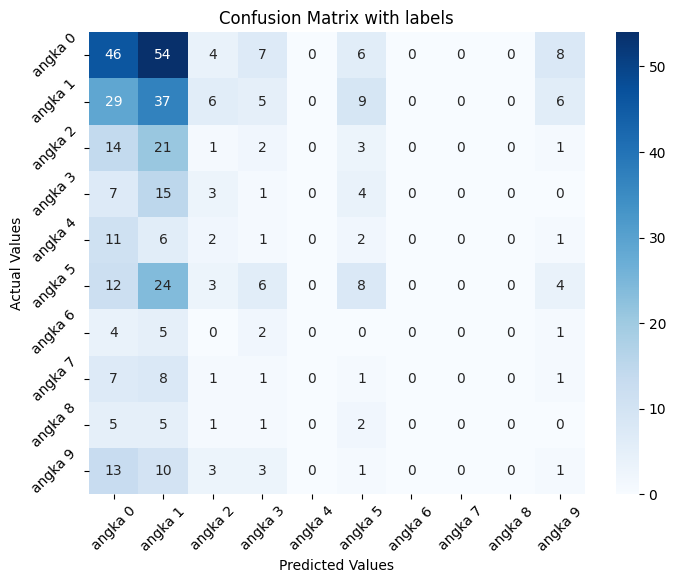

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Fungsi untuk mendapatkan prediksi model dan label sebenarnya
def get_predictions_and_labels(model, data_generator):
    predictions = model.predict(data_generator)
    true_classes = data_generator.classes
    return predictions, true_classes

# Mendapatkan prediksi dan label sebenarnya untuk data uji
y_pred_prob, y_true = get_predictions_and_labels(model2c, test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Membuat matriks konfusi
cf_matrix = confusion_matrix(y_true, y_pred)

# Membuat visualisasi matriks konfusi
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', ax=ax)

# Menetapkan label dan judul
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

class_labels = list(test_generator.class_indices.keys())

# Menetapkan label pada sumbu x dan y sesuai dengan jenis kelas
ax.xaxis.set_ticklabels(class_labels, rotation=45)
ax.yaxis.set_ticklabels(class_labels, rotation=45)

# Menampilkan visualisasi Matriks Konfusi
plt.show()

In [25]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.21123595505617979
